<a href="https://colab.research.google.com/github/mvharsh/Deep-Learning/blob/main/RNN/RNN_Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import Necessary Libraries:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error
import seaborn as sns


#**Load and Preprocess Data:**

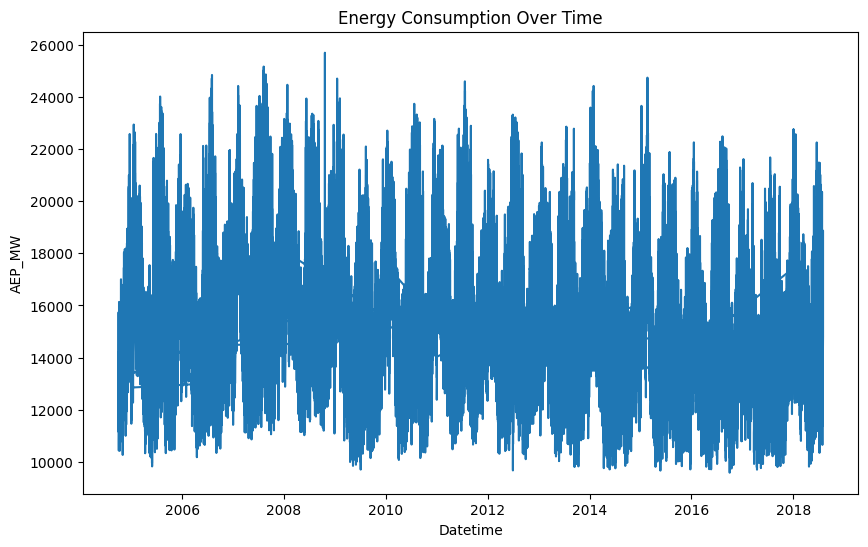

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/AEP_hourly.csv")

# Convert date to datetime
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data['Datetime'], data['AEP_MW'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.show()


Statistical Summary of the Data:
                            Datetime         AEP_MW
count                         121273  121273.000000
mean   2011-09-02 03:17:01.553025024   15499.513717
min              2004-10-01 01:00:00    9581.000000
25%              2008-03-17 15:00:00   13630.000000
50%              2011-09-02 04:00:00   15310.000000
75%              2015-02-16 17:00:00   17200.000000
max              2018-08-03 00:00:00   25695.000000
std                              NaN    2591.399065


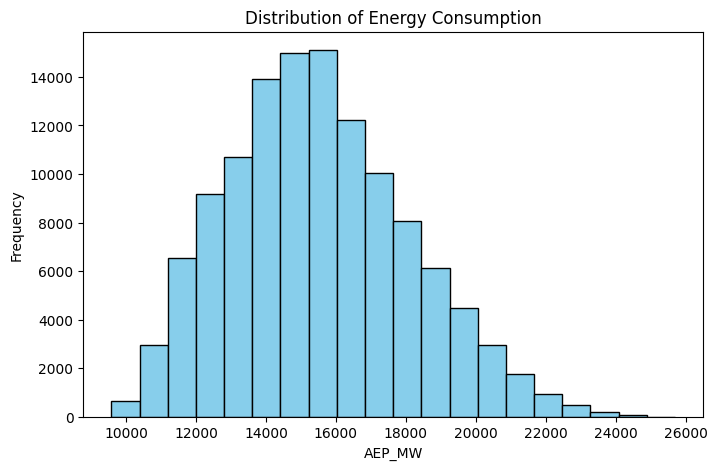

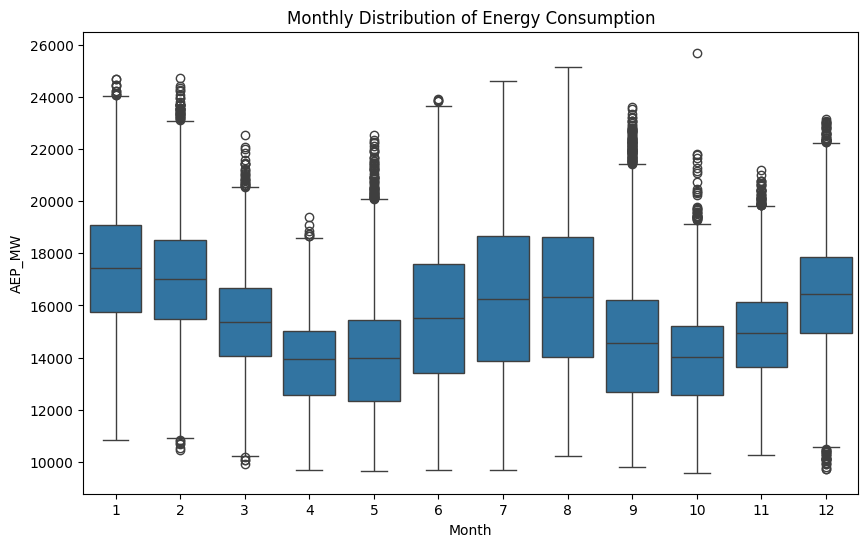

In [ ]:
# Statistical Summary
print("Statistical Summary of the Data:")
print(data.describe())

# Distribution of Production
plt.figure(figsize=(8, 5))
plt.hist(data['AEP_MW'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Energy Consumption')
plt.xlabel('AEP_MW')
plt.ylabel('Frequency')
plt.show()

# Boxplot of Production by Month
data['Month'] = data['Datetime'].dt.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='AEP_MW', data=data)
plt.title('Monthly Distribution of Energy Consumption')
plt.xlabel('Month')
plt.ylabel('AEP_MW')
plt.show()


In [ ]:
# Prepare data
scaler = MinMaxScaler()
data['AEP_MW'] = scaler.fit_transform(data['AEP_MW'].values.reshape(-1,1))

#**Create Training and Testing Data:**

In [ ]:
# Split data into train and test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

# Function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12

X_train, y_train = create_dataset(train[['AEP_MW']], train['AEP_MW'], time_steps)
X_test, y_test = create_dataset(test[['AEP_MW']], test['AEP_MW'], time_steps)


#**Build and Train RNN Model:**

In [ ]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1, shuffle=False)


Epoch 1/100
5457/5457 [==============================] - 16s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/100
5457/5457 [==============================] - 16s 3ms/step - loss: 8.6229e-04 - val_loss: 0.0013
Epoch 3/100
5457/5457 [==============================] - 15s 3ms/step - loss: 8.5584e-04 - val_loss: 0.0012
Epoch 4/100
5457/5457 [==============================] - 16s 3ms/step - loss: 8.5622e-04 - val_loss: 0.0012
Epoch 5/100
5457/5457 [==============================] - 15s 3ms/step - loss: 8.5160e-04 - val_loss: 0.0012
Epoch 6/100
5457/5457 [==============================] - 16s 3ms/step - loss: 8.4374e-04 - val_loss: 0.0011
Epoch 7/100
5457/5457 [==============================] - 16s 3ms/step - loss: 8.3951e-04 - val_loss: 0.0011
Epoch 8/100
5457/5457 [==============================] - 15s 3ms/step - loss: 8.3701e-04 - val_loss: 0.0011
Epoch 9/100
5457/5457 [==============================] - 15s 3ms/step - loss: 8.3317e-04 - val_loss: 0.0011
Epoch 10/100
5457/5457 [========

#**Evaluate the Model:**

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


758/758 [==============================] - 1s 1ms/step
Train RMSE: 577.3286325359376
Test RMSE: 533.754946622302


In [ ]:
# Define a threshold (e.g., +/- 5% of the actual value)
threshold = 0.05

# Calculate the percentage of predictions within the threshold
train_accuracy = np.sum(np.abs(train_predict[:,0] - y_train[0]) / y_train[0] <= threshold) / len(y_train[0])
test_accuracy = np.sum(np.abs(test_predict[:,0] - y_test[0]) / y_test[0] <= threshold) / len(y_test[0])

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Train Accuracy: 87.97%
Test Accuracy: 90.78%


#**Visualize Predictions:**

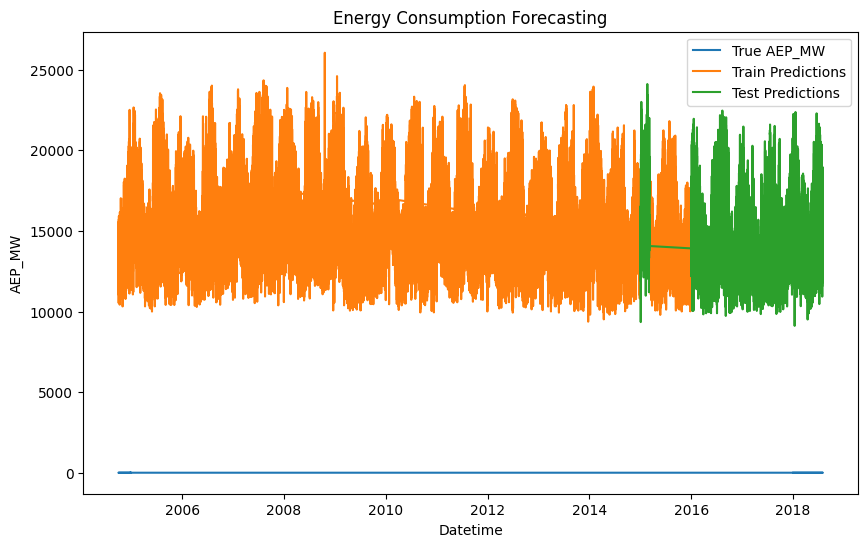

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(data['Datetime'], data['AEP_MW'], label='True AEP_MW')
plt.plot(train['Datetime'].iloc[time_steps:], train_predict, label='Train Predictions')
plt.plot(test['Datetime'].iloc[time_steps:], test_predict, label='Test Predictions')

plt.title('Energy Consumption Forecasting')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()
